# Main Question: Is `loss per capita` per MSA (Bldg) related to the `P/I` ratio across MSAs?

### Answer: There is a statistically significant positive association (p < 0.001) between `loss per capita (bldg)` and the `price-to-income (P/I) ratio` across MSAs. However, this relationship is not linear: the P/I ratio tends to increase with loss up to a certain level, but decreases beyond a certain threshold.

## **Statistical Testing**

## 1) Global level correlation : Weak positive correlation (r:0.27)
## 2) By quantile group:
- ### Q1-2: Increasing trend
- ### Q3-4 : Decreasing trend

## 3) OLS: P/I in Q4 is higher than in Q1. (** Violates Noramlity)
## 4) Dunn Test: Q4 differs significantly from other groups

# Start: Settings

In [5]:
import pandas as pd
import numpy as np
# Disable scientific notation & add commas
pd.set_option('display.float_format', '{:,.2f}'.format)
# Show all columns without truncation
pd.set_option('display.max_columns', None)
# Show full column width (helpful for long strings)
pd.set_option('display.max_colwidth', None)
# Limit the number of rows displayed in output
pd.set_option('display.max_rows', 20)

# Try 1. Global Level correlation

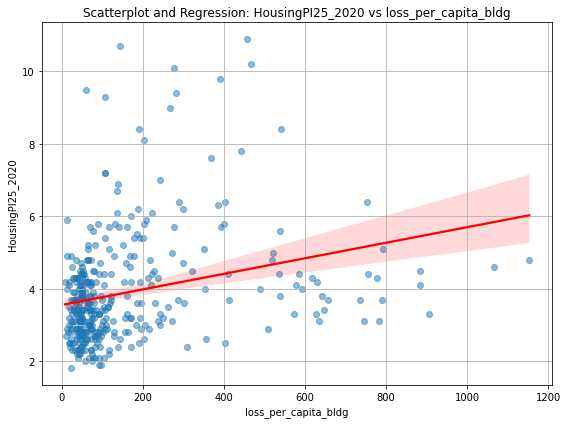

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Load data
df = pd.read_csv("df_with_index.csv")
df['loss_per_capita_total'] = df['loss_per_capita_pe'] + df['loss_per_capita_bldg']
df = df.dropna()

# Define variables
x_variable = 'loss_per_capita_bldg'
y_variable = 'HousingPI25_2020'
x = df[x_variable]
y = df[y_variable]

# Scatterplot with regression line
plt.figure(figsize=(8, 6))
sns.regplot(x=x, y=y, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.xlabel(x_variable)
plt.ylabel(y_variable)
plt.title(f'Scatterplot and Regression: {y_variable} vs {x_variable}')
plt.grid(True)
plt.tight_layout()
plt.show()

## 1-2. Regression Summary

- ### Both original scale and log-transformed models were tested. (unit increase different)
- ### The log-transformed : improved explanatory power and stronger correlation 
- ### The log scale allows for a more intuitive interpretation — e.g., how doubling the loss relates to proportional changes in housing prices.

In [8]:
import pandas as pd
import numpy as np
import scipy.stats as stats

# df_log
df['log_loss'] = np.log(df[x_variable])

# stat calculation
def compute_full_regression_stats(x, y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    r_squared = r_value ** 2
    return {
        'slope': slope,
        'intercept': intercept,
        'r': r_value,
        'R_squared': r_squared,
        'p_value': p_value
    }

stats_original = compute_full_regression_stats(df[x_variable], df[y_variable])
stats_log = compute_full_regression_stats(df['log_loss'], df[y_variable])

# DataFrame
global_regression = pd.DataFrame([
    {
        'Scale': 'Original',
        **stats_original
    },
    {
        'Scale': 'Log-transformed',
        **stats_log
    }
])

global_regression

,Scale,slope,intercept,r,R_squared,p_value
0,Original,0.00,3.55,0.27,0.07,0.00
1,Log-transformed,0.54,1.42,0.35,0.12,0.00


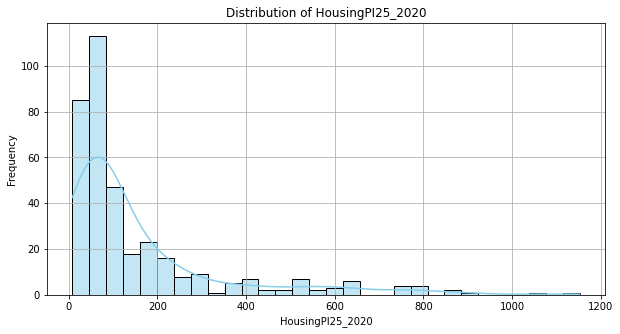

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Let's say your x is already cleaned: 
# x = df['building_total_loss'].astype(float).dropna().values
x = df[x_variable].values

plt.figure(figsize=(10, 5))

# Histogram + KDE (smooth curve)
sns.histplot(x, bins=30, kde=True, color='skyblue')

plt.xlabel(y_variable)
plt.ylabel('Frequency')
plt.title(f'Distribution of {y_variable}')
plt.grid(True)
plt.show()


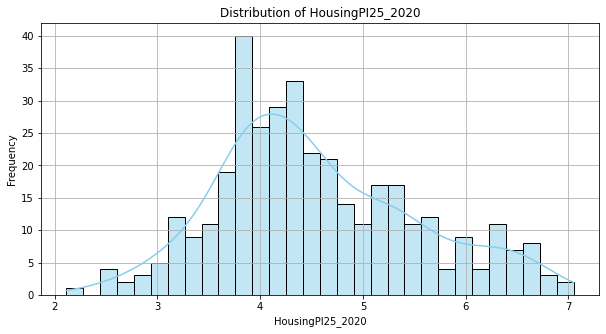

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

x = np.log(df[x_variable])

plt.figure(figsize=(10, 5))

# Histogram + KDE (smooth curve)
sns.histplot(x, bins=30, kde=True, color='skyblue')

plt.xlabel(y_variable)
plt.ylabel('Frequency')
plt.title(f'Distribution of {y_variable}')
plt.grid(True)
plt.show()


# Try 2. Piecewise Regression
- ### Choose log-transformed scale

## Why Piecewise Regression?
- ### the overall relationship appears weak, but certain segments may have distinct linear patterns
  - For example: “There’s no clear trend when X is small, but after a certain threshold, X starts to affect Y”

## How?
- ### The X-axis is divided into multiple segments
- ### For each segment, fit a separate linear regression and compare them

## Result: 
### Pearson’s r increased within each segment, indicating that the piecewise approach better captures the non-linear relationship between the two variables.

In [12]:
segment_number = 2

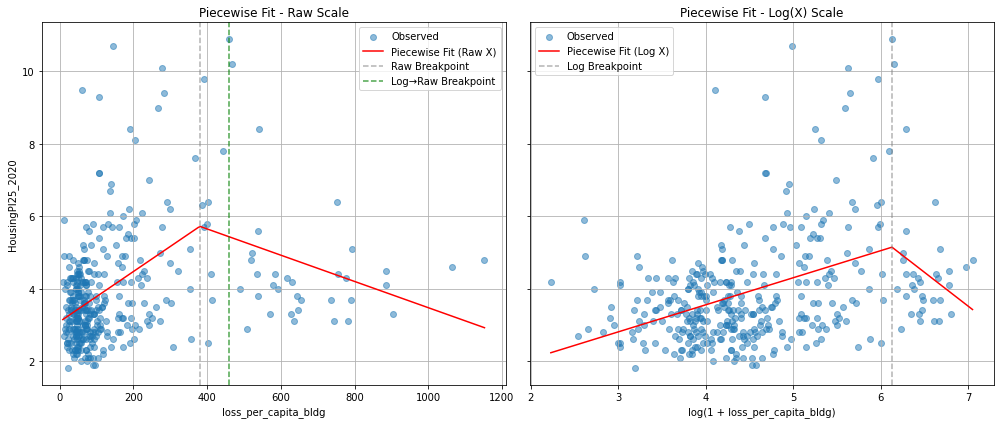

Break points - Original Scale: [   8.28333891  380.1702268  1152.487016  ]
Break Points - Log Scale (back-transformed): [   8.28333891  458.01090608 1152.487016  ]
piecewise original
  Scale  Segment  X_Start    X_End  N_Points  Slope  Intercept     r   R2  \
0   Raw        1     8.28   380.17       324   0.01       3.09  0.37 0.14   
1   Raw        2   380.17 1,152.49        43  -0.00       7.10 -0.34 0.12   

   p_value  
0     0.00  
1     0.02  
piecewise_log_scale
      Scale  Segment  X_Start  X_End  N_Points  Slope  Intercept     r   R2  \
0  Log(1+x)        1     2.23   6.13       333   0.71       0.73  0.37 0.14   
1  Log(1+x)        2     6.13   7.05        34  -2.77      22.59 -0.35 0.12   

   p_value  
0     0.00  
1     0.04  


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import r2_score
import pwlf

# === Define column names and extract data ===
x_raw = df[x_variable].values
y = df[y_variable].values
x_log = np.log1p(x_raw)

# === Fit models ===
model_raw = pwlf.PiecewiseLinFit(x_raw, y)
breaks_raw = model_raw.fit(segment_number)
y_hat_raw = model_raw.predict(np.linspace(min(x_raw), max(x_raw), 200))

model_log = pwlf.PiecewiseLinFit(x_log, y)
breaks_log = model_log.fit(segment_number)
breaks_log_raw = np.expm1(breaks_log)
y_hat_log = model_log.predict(np.linspace(min(x_log), max(x_log), 200))

# === Plot raw vs log-scale piecewise fits ===
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# --- Plot 1: Raw X ---
axes[0].scatter(x_raw, y, alpha=0.5, label='Observed')
axes[0].plot(np.linspace(min(x_raw), max(x_raw), 200), y_hat_raw, color='red', label='Piecewise Fit (Raw X)')
for bp in breaks_raw[1:-1]:
    axes[0].axvline(bp, linestyle='--', color='gray', alpha=0.6, label='Raw Breakpoint' if bp == breaks_raw[1] else "")
for bp in breaks_log_raw[1:-1]:
    axes[0].axvline(bp, linestyle='--', color='green', alpha=0.7, label='Log→Raw Breakpoint' if bp == breaks_log_raw[1] else "")
axes[0].set_title('Piecewise Fit - Raw Scale')
axes[0].set_xlabel(x_variable)
axes[0].set_ylabel(y_variable)
axes[0].legend()
axes[0].grid(True)

# --- Plot 2: Log X ---
axes[1].scatter(x_log, y, alpha=0.5, label='Observed')
axes[1].plot(np.linspace(min(x_log), max(x_log), 200), y_hat_log, color='red', label='Piecewise Fit (Log X)')
for bp in breaks_log[1:-1]:
    axes[1].axvline(bp, linestyle='--', color='gray', alpha=0.6, label='Log Breakpoint' if bp == breaks_log[1] else "")
axes[1].set_title('Piecewise Fit - Log(X) Scale')
axes[1].set_xlabel(f'log(1 + {x_variable})')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# === Print breakpoints ===
print("Break points - Original Scale:", breaks_raw)
print("Break Points - Log Scale (back-transformed):", breaks_log_raw)

from scipy.stats import pearsonr
from scipy.stats import linregress

def generate_segment_summary_df(x, y, model, scale_label):
    breaks = model.fit_breaks
    summary = []

    for i in range(len(breaks) - 1):
        mask = (x >= breaks[i]) & (x <= breaks[i+1])
        x_seg = x[mask]
        y_seg = y[mask]

        if len(x_seg) > 1:
            slope, intercept, r_value, p_value, std_err = linregress(x_seg, y_seg)
            r2 = r_value ** 2
        else:
            slope = intercept = r_value = p_value = r2 = None

        summary.append({
            "Scale": scale_label,
            "Segment": i + 1,
            "X_Start": round(breaks[i], 4),
            "X_End": round(breaks[i+1], 4),
            "N_Points": len(x_seg),
            "Slope": round(slope, 4) if slope is not None else None,
            "Intercept": round(intercept, 4) if intercept is not None else None,
            "r": round(r_value, 4) if r_value is not None else None,
            "R2": round(r2, 4) if r2 is not None else None,
            "p_value": round(p_value, 6) if p_value is not None else None
        })

    return pd.DataFrame(summary)

# === Generate and display summary table for raw model ===
piecewise_original = generate_segment_summary_df(x_raw, y, model_raw, scale_label='Raw')
print('piecewise original')
print(piecewise_original)
# === Generate and display summary table for log-transformed model ===
piecewise_log_scale = generate_segment_summary_df(x_log, y, model_log, scale_label='Log(1+x)')
print('piecewise_log_scale')
print(piecewise_log_scale)

In [14]:
global_regression

,Scale,slope,intercept,r,R_squared,p_value
0,Original,0.00,3.55,0.27,0.07,0.00
1,Log-transformed,0.54,1.42,0.35,0.12,0.00


In [15]:
piecewise_original

,Scale,Segment,X_Start,X_End,N_Points,Slope,Intercept,r,R2,p_value
0,Raw,1,8.28,380.17,324,0.01,3.09,0.37,0.14,0.00
1,Raw,2,380.17,"1,152.49",43,-0.00,7.10,-0.34,0.12,0.02


In [16]:
piecewise_log_scale

,Scale,Segment,X_Start,X_End,N_Points,Slope,Intercept,r,R2,p_value
0,Log(1+x),1,2.23,6.13,333,0.71,0.73,0.37,0.14,0.00
1,Log(1+x),2,6.13,7.05,34,-2.77,22.59,-0.35,0.12,0.04


# Try 3 - Crosstab
- ## crosstab simply checks whether different groups show distinct distributions of outcomes

## 3.1 Binning into 4 Quantiles

In [17]:
df['loss_bin'], loss_bins = pd.qcut(df[x_variable], q=4, labels=["Q1", "Q2", "Q3", "Q4"], retbins=True)
df['hpi_bin'], hpi_bins = pd.qcut(df[y_variable], q=4, labels=["Low", "Mid-Low", "Mid-High", "High"], retbins=True)

print("Loss bins:", loss_bins)
print("HPI bins:", hpi_bins)

print(df['loss_bin'].value_counts())
print(df['hpi_bin'].value_counts())

Loss bins: [   8.28333891   48.14976844   78.28643511  181.06717088 1152.487016  ]
HPI bins: [ 1.8  2.9  3.5  4.4 10.9]
loss_bin
Q1    92
Q2    92
Q4    92
Q3    91
Name: count, dtype: int64
hpi_bin
Low         100
Mid-High     98
Mid-Low      85
High         84
Name: count, dtype: int64


## 3.2 Vizualize Binnings

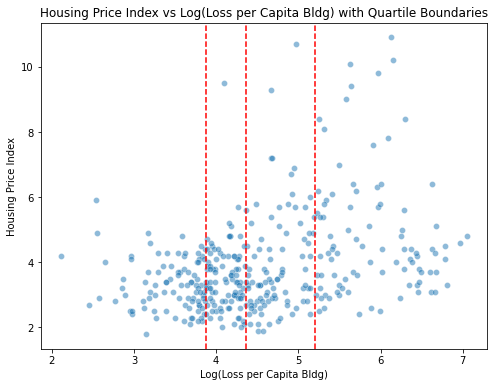

In [18]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='log_loss', y=y_variable, data=df, alpha=0.5)
for q in df['log_loss'].quantile([0.25, 0.5, 0.75]):
    plt.axvline(x=q, color='red', linestyle='--')
plt.title('Housing Price Index vs Log(Loss per Capita Bldg) with Quartile Boundaries')
plt.xlabel('Log(Loss per Capita Bldg)')
plt.ylabel('Housing Price Index')
plt.show()

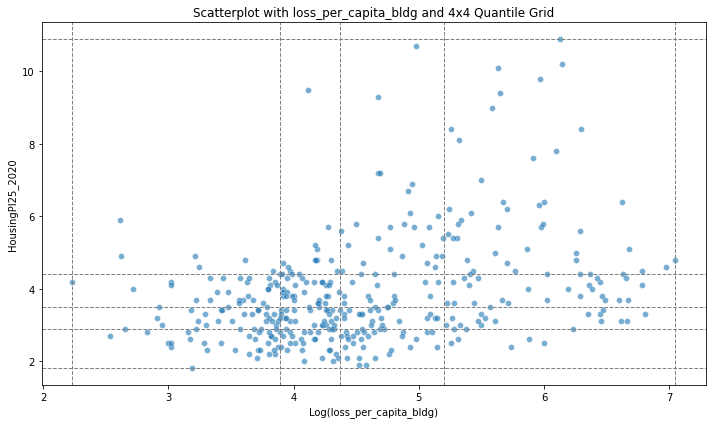

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. create a log transfored column 
df['log_loss'] = np.log1p(df[x_variable])

# 2. binning
_, loss_bins_log = pd.qcut(df['log_loss'], q=4, retbins=True)
_, hpi_bins = pd.qcut(df[y_variable], q=4, retbins=True)

# 3. scatterplot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='log_loss', y=y_variable, data=df, alpha=0.6)

# vertical line (log-loss)
for x in loss_bins_log:
    plt.axvline(x=x, color='gray', linestyle='--', linewidth=1)

# horizontal line (pi)
for y in hpi_bins:
    plt.axhline(y=y, color='gray', linestyle='--', linewidth=1)

# title and labels
plt.title(f'Scatterplot with {x_variable} and 4x4 Quantile Grid')
plt.xlabel(f'Log({x_variable})')
plt.ylabel(f'{y_variable}')
plt.grid(False)
plt.tight_layout()
plt.show()


## 3.3 Heatmap

log_hpi_bin   Low  Mid-Low  Mid-High  High
log_loss_bin                              
Q1           0.38     0.27      0.28  0.07
Q2           0.29     0.26      0.32  0.13
Q3           0.33     0.22      0.16  0.29
Q4           0.09     0.17      0.30  0.43


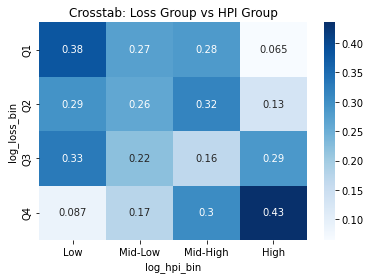

In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df['log_loss'] = np.log1p(df[x_variable])
df['log_hpi'] = np.log1p(df[y_variable])

# 4 quantiles
df['log_loss_bin'] = pd.qcut(df['log_loss'], q=4, labels=["Q1", "Q2", "Q3", "Q4"])
df['log_hpi_bin'] = pd.qcut(df['log_hpi'], q=4, labels=["Low", "Mid-Low", "Mid-High", "High"])

# 3. crosstab
ct_log = pd.crosstab(df['log_loss_bin'], df['log_hpi_bin'], normalize='index')
print(ct_log)

sns.heatmap(ct_log, annot=True, cmap='Blues')
plt.title('Crosstab: Loss Group vs HPI Group')
plt.show()

## 3.4 Mean in each segment

In [24]:
df.groupby(['loss_bin'])[y_variable].mean()

/var/folders/1p/tv5xxzg57bdfnzbf6kwqqfsr0000gn/T/ipykernel_97630/3977899909.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(['loss_bin'])[y_variable].mean()


loss_bin
Q1   3.31
Q2   3.53
Q3   3.90
Q4   4.82
Name: HousingPI25_2020, dtype: float64

In [25]:
# loss_bin, hpi_bin combinationed HousingPI (mean)
df.groupby(['loss_bin', 'hpi_bin'])[y_variable].mean().unstack()

/var/folders/1p/tv5xxzg57bdfnzbf6kwqqfsr0000gn/T/ipykernel_97630/3776701503.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(['loss_bin', 'hpi_bin'])[y_variable].mean().unstack()


hpi_bin,Low,Mid-Low,Mid-High,High
loss_bin,,,,
Q1,2.55,3.25,4.01,4.93
Q2,2.52,3.24,3.99,5.25
Q3,2.54,3.27,3.98,5.92
Q4,2.66,3.19,4.01,6.47


# Try 4. OLS regrsssion

### "Regions with higher disaster losses (Q4) tend to have higher average housing prices." (Q3 and Q4 show significantly higher HPI than Q1)



### Although the overall R² from a single regression is not high, grouping into quartiles reveals meaningful differences across segments.

In [20]:
# X: loss bin (Q1, Q2, Q3, Q4)
# Y: Housing Price index

In [26]:
import statsmodels.formula.api as smf

df['loss_bin'] = df['loss_bin'].astype(str)
df['hpi_bin'] = df['hpi_bin'].astype(str)

model = smf.ols(f'{y_variable} ~ loss_bin', data=df).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:       HousingPI25_2020   R-squared:                       0.147
Model:                            OLS   Adj. R-squared:                  0.140
Method:                 Least Squares   F-statistic:                     20.82
Date:                Sun, 03 Aug 2025   Prob (F-statistic):           1.81e-12
Time:                        23:17:41   Log-Likelihood:                -643.11
No. Observations:                 367   AIC:                             1294.
Df Residuals:                     363   BIC:                             1310.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          3.3087      0.146     22.

### Justification for Using the Kruskal–Wallis Test

We evaluated group differences in housing price index across loss bins (bldg) using both parametric and non-parametric methods.

#### 1. Assumption Checks
- **Normality**: Shapiro–Wilk tests revealed that most groups significantly deviate from normality  
  (e.g., Group Q2–Q4: p < 0.001).
- **Homogeneity of variances**: Levene’s test indicated unequal variances across groups (stat = 10.512, p < 0.001).

#### 2. Parametric vs. Non-parametric Tests
| Test | Statistic | p-value | Conclusion |
|------|-----------|---------|------------|
| **ANOVA** | F = 20.820 | p < 0.001 | Significant, but assumptions violated |
| **Kruskal–Wallis** | H = 46.123 | p < 0.001 | Significant, robust to assumption violations |

Given the violation of both normality and homoscedasticity assumptions, we rely on the **Kruskal–Wallis test**. This non-parametric method does not assume normal distribution or equal variances, making it more appropriate for our data.

➡️ **Conclusion**: The Kruskal–Wallis test confirms that there are statistically significant differences in housing price index across loss bins.


In [27]:
# Normality - low p value ? deviated from normality
from scipy.stats import shapiro

for name, group in df.groupby("loss_bin"):
    stat, p = shapiro(group[y_variable])
    print(f"Group {name}: W = {stat:.4f}, p = {p:.4f}")


Group Q1: W = 0.9699, p = 0.0317
Group Q2: W = 0.8532, p = 0.0000
Group Q3: W = 0.8651, p = 0.0000
Group Q4: W = 0.8698, p = 0.0000


In [29]:
# low p-value: equal variance is violated
from scipy.stats import levene
groups = [group[y_variable].values for _, group in df.groupby("loss_bin")]
stat, p = levene(*groups)
print(f"Levene’s test for equal variances: stat = {stat:.3f}, p = {p:.4f}")

Levene’s test for equal variances: stat = 10.512, p = 0.0000


In [33]:
# High F/H value & low p-value → strong evidence of group differences
from scipy.stats import f_oneway, kruskal

anova_stat, anova_p = f_oneway(*groups)
kruskal_stat, kruskal_p = kruskal(*groups)

print(f"ANOVA: F = {anova_stat:.3f}, p = {anova_p:.4f}")
print(f"Kruskal-Wallis: H = {kruskal_stat:.3f}, p = {kruskal_p:.4f}")


ANOVA: F = 20.820, p = 0.0000
Kruskal-Wallis: H = 46.123, p = 0.0000


### Dunn’s test shows more significant differences at higher loss levels (e.g., Q4 vs Q1, Q2)


In [36]:
import pandas as pd
import scikit_posthocs as sp
from scipy.stats import kruskal

# Dunn’s Test
# low p-value: siginificantly difference
dunn_results = sp.posthoc_dunn(df, val_col=y_variable, group_col='loss_bin', p_adjust='bonferroni')
print("\nDunn’s Test with Bonferroni Correction:")
print(dunn_results)


Dunn’s Test with Bonferroni Correction:
     Q1   Q2   Q3   Q4
Q1 1.00 1.00 0.13 0.00
Q2 1.00 1.00 1.00 0.00
Q3 0.13 1.00 1.00 0.00
Q4 0.00 0.00 0.00 1.00
